In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from fastdtw import fastdtw
from tqdm.auto import tqdm
from typing import *
import pandas as pd
import numpy as np
from PyEMD import EMD
import Sample
import pickle
import torch
import os
import warnings

warnings.filterwarnings('ignore')

## Data analysis and preprocess

### Training dataset

Four datasets are used in our train from the two labs: linux foundation lab and china mobile lab,   
mixedbag-2hours-cpuper-node5（node5)   
mixedbag-2hours-cpuper-node4（node4）   
k8s-worker-2（worker2）   
k8s-worker-1（worker1）

Other two datasets with 30min sampling window are excluded from our training set because their sampling time is not synchronized together.

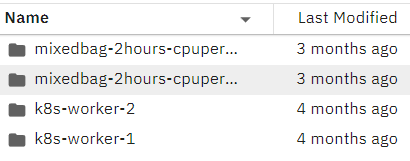

The description of the features in the original dataset,

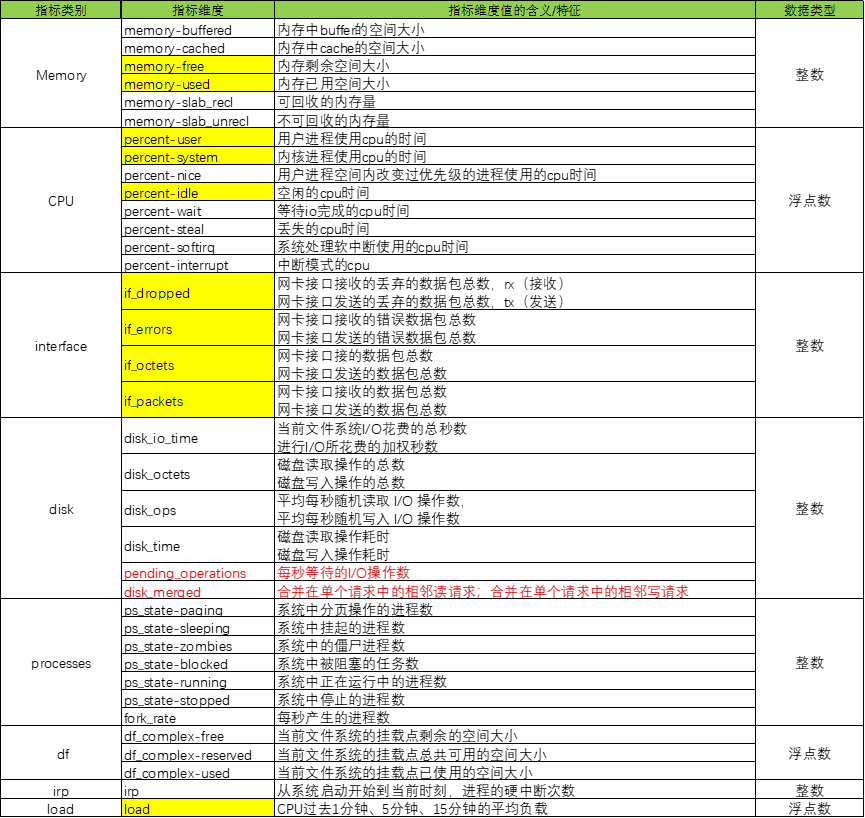

The features are required to generate in our GAN,

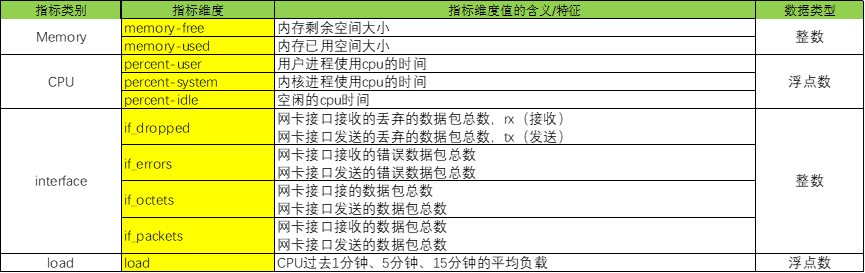

### Data facts

#### A.  Sampling time is not uniform

The sampling period is centered in 1 sec but widely spreaded as shown below. So we only use the sampling data with 1 sec in our task.  

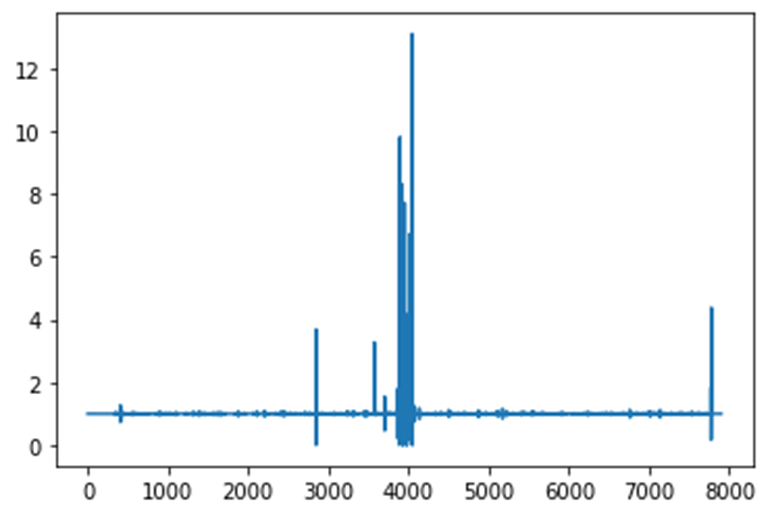

#### B. The features

In the training dataset, the number of data files is various under the same features because the data is sampled from the different CPUs, disks, interfaces installed on one dividual node. We take a summation of the corresponding  hardware data and then learn the CPU and interface total load in one node. 

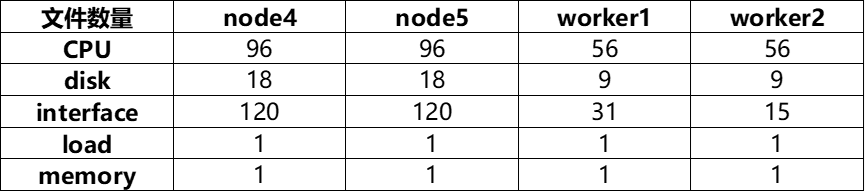

The features are sampled from the four different nodes: node4, node5, worker1, worker2. It is found that the features are not identically distributed from the different nodes. The distributions of the feature "memory_free" from worker1 and node4 are shown below. So we train the different GAN models for the node4, node4, worker1, worker2, individually.

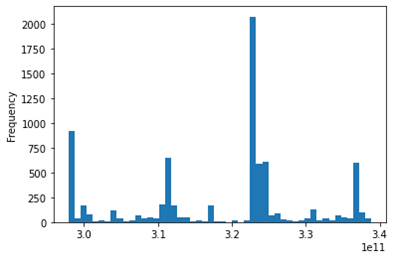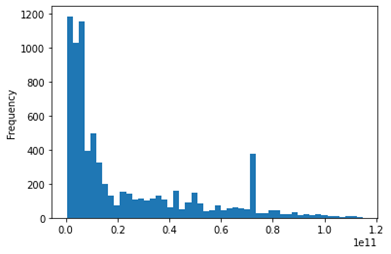

#### C. The time series of features are not stationary

We find the time series of features are not stationary, so the temporal order is ignored in our generative process. The time series can be rebuilt from the load data after the generation.

#### D. load is the dominant factor to determine the tendency of CPU, memory features  

From the heatmaps below, we find the CPU, memory and load are strongly correlated while the correlations are weak between the interface, disk and load. So we design two generation processes for the group of CPU, memory and load and for the interface, respectively. 

The load determines the tendency of CPU, memory. However, our training data is sampled only in two hours which greatly restricts the generated data patterns. The test load as an input condition is usually required in our generation to capture the tendency.

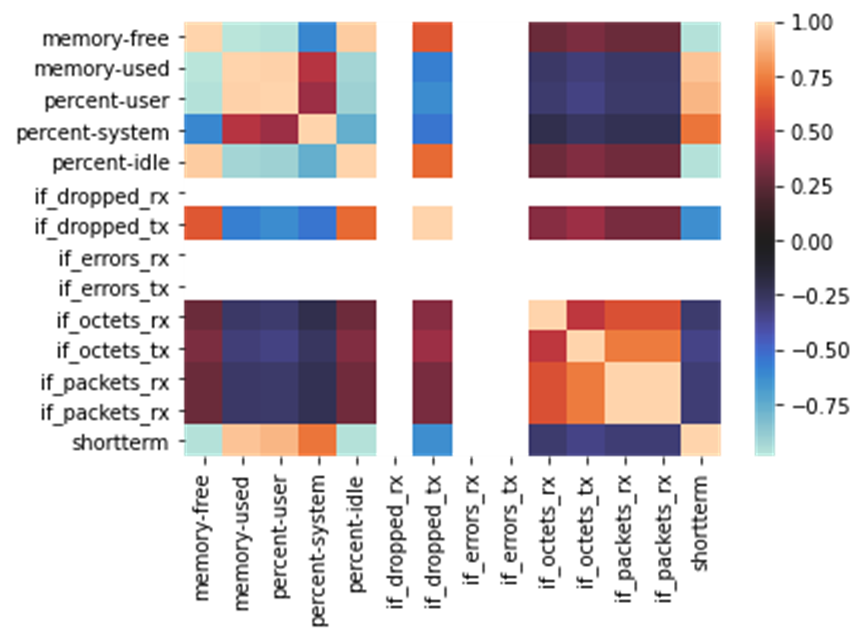

### Data cleansing

According to the data facts we have found from the original data, we clean and filter our training dataset,
1. The foreign key epoch is converted to the integers and removes the repeated ones;
2. The sampling data with 1 sec is used in our task;
3. Sum up the corresponding CPU, interface data in one node;
4. The GAN model is individually trained for the node4, node4, worker1, worker2;
5. Remove the data rows with the value 'nan';
6. The GAN model can be conditioned by the tendency of the load.

In [2]:
# scientific notation is closed
pd.set_option('display.float_format',lambda x : '%.2f' % x)

def choose_filename(path,startwith):
    """
    locate the files starting with startwith
    :param path: str folder path
    :param startwith: str substring start with 
    :return: list filenames
    """
    return [os.path.join(path,i) for i in os.listdir(path) if i.startswith(startwith)]


def pd_concat(lists):
    """
    concatence a list of pandas dataframes into one dataframe
    :param lists: a list of pandas dataframes 
    :return: joined dataframe
    """
    df = lists[0]
    for i in lists[1:]:
        df = df.join(i,how='left')
    return df


class DataCleansing():
    """
    The utility collections for the data preprocessing
    """
    def __init__(self, node_file):
        self.node_file = node_file
        self.feature_dict = [
            ['cpu', ['per']], 
            ['memory', ['memory']],
            ['interface', ['if']], 
            ['load', ['load']], 
            # ['process', ['ps', 'fork']], 
            # ['disk', ['disk']], 
            # ['df', ['df']],
        ]

    def preprocess(self):
        """
        The entrance of data preprocess
        """
        data_list = []
        for i in self.feature_dict:
            data = self.concat_file(file_start = i[0],second_start_list = i[1])
            data_sum = self.sum_data(data)
            data_list.append(data_sum)
        cleaned_data = pd.concat(data_list,axis=1)
        return cleaned_data
    
    def sum_data(self,data_list,save_more=True):
        """
        sum the hardware data from the various sources in one node 
        """
        data0 = data_list[0]
        for datai in data_list[1:]:
            if save_more:
                datat = data0 + datai
                datat.fillna(data0,inplace=True)
                datat.fillna(datai,inplace=True)
                data0 = datat
            else:
                data0 += datai
        return data0
        
    def concat_file(self, file_start:str='df',second_start_list:List[str]=['df']):
        """
        concatence the hardware data from the various sources in one node 
        """
        data_list = []
        for path in tqdm(choose_filename(self.node_file, file_start)):
            file_list = []
            for start in second_start_list:
                file_list += choose_filename(path, start)                
            # join the files into one dataframe
            con_data = self._concat_data(file_list, second_start_list)
            # epoch is converted to the integer type
            con_data.index = con_data.index.astype(int)
            con_data = con_data[~con_data.index.duplicated(keep='first')]
            data_list.append(con_data)
        return data_list

    def _concat_data(self,file_list, start_list=['per']):
        if 'if' in start_list:
            lists = [ self._interface_rename(file_list_id) for file_list_id in file_list]
        elif 'disk' in start_list:
            lists = [ self._disk_rename(file_list_id) for file_list_id in file_list]
        else:
            lists = [ self._general_rename(file_list_id) for file_list_id in file_list]
        return pd_concat(lists)

    def _interface_rename(self,file_list_id):
        interface_df = pd.read_csv(file_list_id).set_index('epoch')
        return interface_df.rename(columns={'rx': file_list_id.split(os.sep)[-1][:-11] + '_rx', 'tx': file_list_id.split(os.sep)[-1][:-11] + '_tx'})

    def _general_rename(self,file_list_id):
        df = pd.read_csv(file_list_id).set_index('epoch')
        return df.rename(columns={'value': file_list_id.split(os.sep)[-1][:-11]})

    def _disk_rename(self,file_list_id):
        disk_df =  pd.read_csv(file_list_id).set_index('epoch')
        files = file_list_id.split(os.sep)[-1]
        if files.startswith('disk_ops'):
            disk_df.columns = ['ops_read', 'ops_write']
        elif files.startswith('disk_time'):
            disk_df.columns = ['time_read', 'time_write']
        elif files.startswith('disk_octets'):
            disk_df.columns = ['octets_read', 'octets_write']
        return disk_df

In [3]:
# Read the original files and  preprocess the data
foldername = 'node4'

if foldername == 'node4':
    node_file = 'metadata/mixedbag-2hours-cpuper-node4/pod18-node4'
    pkl_str = 'models/node4.pkl'
elif foldername == 'node5':
    node_file = 'metadata/mixedbag-2hours-cpuper-node4/pod18-node4'
    pkl_str = 'models/node5.pkl'
elif foldername == 'worker1':
    node_file = 'metadata/k8s-worker-1'
    pkl_str = 'models/worker1.pkl'
elif foldername == 'worker2':
    node_file = 'metadata/k8s-worker-2'
    pkl_str = 'models/worker2.pkl'
else:
    pass


meta_data_ = DataCleansing(node_file).preprocess()
meta_data = meta_data_

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

The data rows with the value 'nan' are dropped,

In [4]:
# The data rows with the value 'nan' are dropped 
columns = ['memory-free', 'memory-used', 'percent-user', 'percent-system', 'percent-idle', 'shortterm', 'midterm', 'longterm']
meta_data = meta_data[columns][1:].dropna()
meta_data.index = range(len(meta_data))

## Data generation

### Generation 1：Load,CPU,memory

#### Load as the input condition

We recommend to provide a test load time series as the input condition of our generation process.

Otherwise, the training load is provided by default.

In [5]:
def get_load(load=None):
    if load is None:
        load = meta_data["shortterm"]
    else:
        pass
    return load

In [6]:
meta_load = get_load()

#### Conditional generation (shutdown the comment if the condition is provided)

In [7]:
# load = meta_data["shortterm"].sort_index(ascending=False)
# load.index = range(len(load))

# meta_load = get_load(load)

#### Call our generation module to generate load,cpu,memory

In [8]:
CTGAN = Sample.QEGAN
Table = Sample.Table
CTGANSynthesizer = Sample.CTGANSynthesizer
DataTransformer = Sample.DataTransformer
DataSampler = Sample.DataSampler
Generator = Sample.Generator
Residual = Sample.Residual

In [9]:
# Setup the parameters for our generation module
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple('ColumnTransformInfo', [
        'column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'])

# Open our trained generative models
with open(pkl_str, 'rb') as f:
    model = pickle.loads(f.read())

In [10]:
nentry = 7000  # the number of synthetic entries

syn_data = model.sample(num_rows=nentry)

In [11]:
syn_data

,memory-free,memory-used,percent-user,percent-system,percent-idle,shortterm
0,307616691914.00,52896230939.00,2235.45,3520.33,6883.14,2109.79
1,325005616512.00,48496591832.00,1737.32,54.20,7664.98,1488.40
2,298001703240.00,63053775523.00,3826.67,1199.54,4205.89,6586.55
3,323164773560.00,49702755564.00,1509.38,252.46,7575.51,2150.52
4,324536469112.00,48463780366.00,1659.89,92.23,7774.79,1476.19
...,...,...,...,...,...,...
6995,311575278573.00,55683697530.00,2792.73,327.79,6323.45,3426.94
6996,323148803638.00,49745353853.00,1317.35,567.24,7622.20,1859.05
6997,336951510406.00,42198743845.00,376.34,79.73,9019.39,124.98
6998,311902282830.00,55840180636.00,2830.04,326.08,6319.26,3053.08


#### Rebuliding the time series

In [12]:
# capture the tendency from the conditioned load
meta_load = meta_load[:nentry].sort_values()

syn_data = syn_data.sort_values('shortterm')
syn_data.index = meta_load.index
syn_data = syn_data.sort_index()

syn_data.index = range(len(syn_data))

memory-free


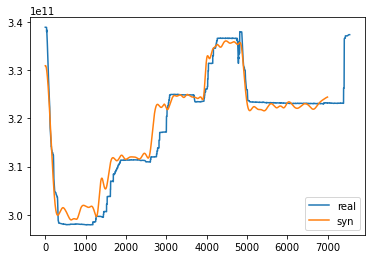

memory-used


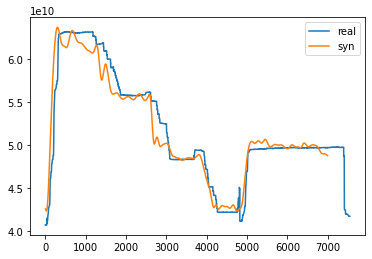

percent-user


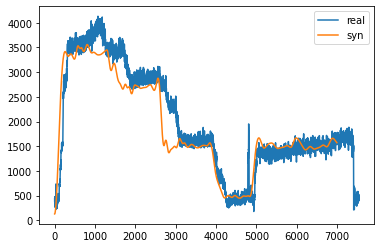

percent-system


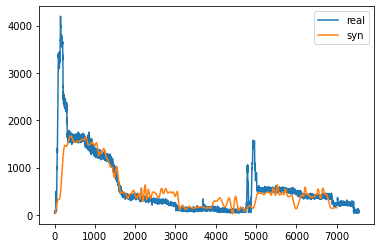

percent-idle


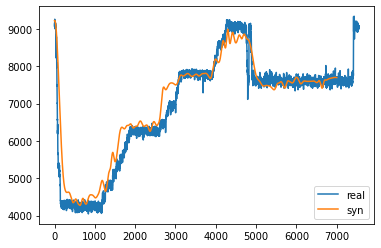

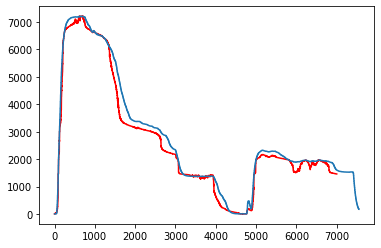

In [13]:
def sort_syn(syn_data=None, level=7):
    """
    Clean the noise due to the time series rearrangement
    """
    trend = []
    res = []
    t = np.arange(len(syn_data))
    columns_ = ['memory-free', 'memory-used', 'percent-user', 'percent-system', 'percent-idle']  # 'shortterm'

    for i in columns_:
        EMD_ = EMD()
        IMF = EMD_.emd(np.array(syn_data[i]), t, level)
        trend_ = IMF[level, :]
        res_ = sum(IMF[0: level-1, :])

        trend.append(trend_)
        res.append(res_)

    trend = pd.DataFrame(trend).T
    res = pd.DataFrame(res).T
    trend.columns = columns_
    res.columns = columns_

    return trend, res

trend, res = sort_syn(syn_data=syn_data)

for i in ['memory-free', 'memory-used', 'percent-user', 'percent-system', 'percent-idle'] :
    print(i)
    plt.plot(meta_data[i])
    plt.plot(trend[i])
    plt.legend(['real','syn'])
    plt.show()
    syn_data[i] = trend[i]

plt.plot(syn_data["shortterm"], 'r')
plt.plot(meta_data["shortterm"])
plt.show()

In [14]:
def runavg(x, width):
    """
    generate the midterm, longterm of the load
    """
    n = len(x)
    x = np.append(x, np.append(x, x))
    x_smooth = np.convolve(x, np.ones(width)/width, mode='same')
    xs = x_smooth[n:2*n]
    return xs

In [15]:
syn_data['midterm'] = runavg(syn_data["shortterm"], 5)
syn_data['longterm'] = runavg(syn_data["shortterm"], 15)

### Generation 2：interface

In [16]:
# The generative utility functions for interface
def clean_data(data):
    """
    clean the noise from the original interface dataset
    """
    mean = data.mean()
    std = data.std()
    interface_df = (data-mean)/std
    return interface_df[(interface_df>-1)&(interface_df<1)]*std + mean

def linear_regress(data):
    linreg = LinearRegression()
    linreg.fit(data.index.values.reshape(-1,1),data.values)
    return linreg.predict(data.index.values.reshape(-1,1))

def generate_if0(data_oct):
    """
    generate the interface data for Packets/Octets
    """
    data = clean_data(data_oct)
    return pd.DataFrame(linear_regress(data),index=data.index,columns=[data.name])

def clean_data1(datas):
    return pd.DataFrame([i.max() for i in datas.rolling(4)])

def stepwise_dropped(data_drop,init_num= 8743,inteval= 1,want_jump_count=2):
    """
    generate stepwise function for the dropped interface
    """
    dropped_shape = data_drop.shape[0]
    data = (np.random.uniform(0,1,(dropped_shape,))<np.array((want_jump_count/dropped_shape))).reshape(-1,1)
    dropped_if = pd.DataFrame(np.zeros_like(data_drop))
    data_mask = dropped_if.mask(data,1)
    return init_num + data_mask.cumsum()*inteval

def generate_if1(data):
    """
    generate the interface data for Dropped/Errors
    """
    init_num = data.iloc[0]
    cdata = clean_data1(data)
    datap = cdata.diff()
    dataq = datap[datap>0].dropna()
    if dataq.empty:
        return data
    else:
        jump_counts = len(dataq)
        jump_interval = dataq.mean()*0.85
        dropped_data = stepwise_dropped(cdata,init_num= init_num,inteval= jump_interval,want_jump_count=jump_counts)
        dropped_data.index = data.index
        return dropped_data

In [17]:
# generate the interface data: syn_interface
syn_interface = pd.DataFrame()

for i in ['if_octets_rx', 'if_octets_tx', 'if_packets_rx', 'if_packets_tx']:
    if0 = generate_if0(meta_data_[i])
    syn_interface = pd.concat([syn_interface, if0], axis=1)

for i in ['if_errors_rx', 'if_errors_tx']:
    syn_interface[i] = 0.0

for i in ['if_dropped_rx', 'if_dropped_tx']:
    if1 = generate_if1(meta_data_[i].fillna(meta_data_[i].mean()))
    syn_interface[i] = if1

## Assement

In [18]:
epoch = syn_interface.index
syn_interface.index = range(len(syn_interface))
syn_interface = syn_interface.iloc[:nentry, :]

In [19]:
syn_data_ = pd.concat([syn_data, syn_interface], axis=1)
syn_data_.index = epoch[:nentry]

### Generated time series

memory-free


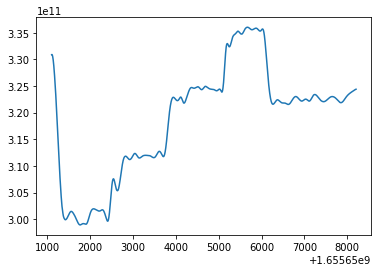

memory-used


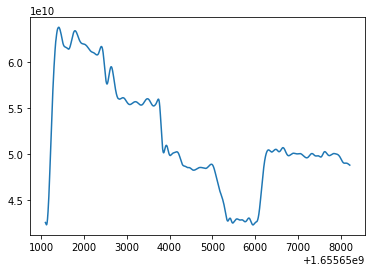

percent-user


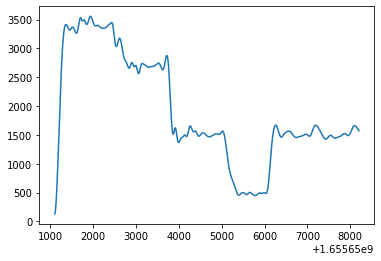

percent-system


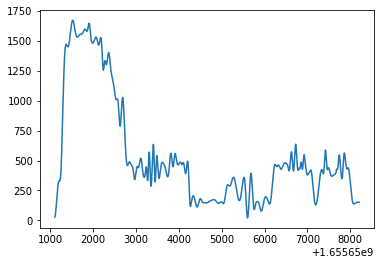

percent-idle


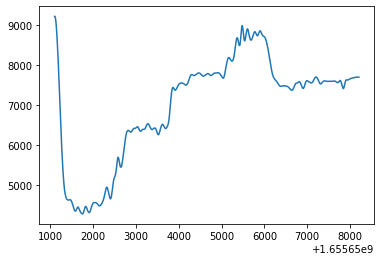

shortterm


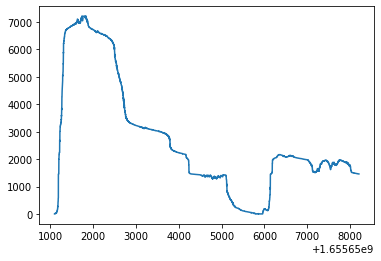

midterm


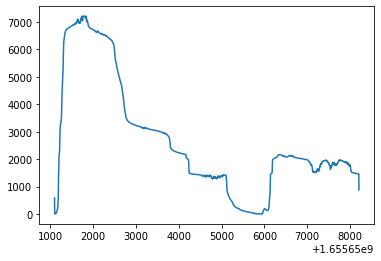

longterm


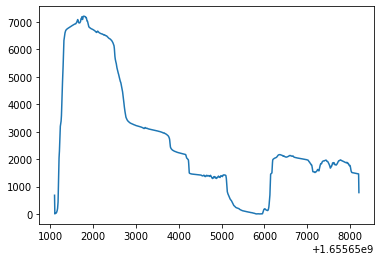

if_octets_rx


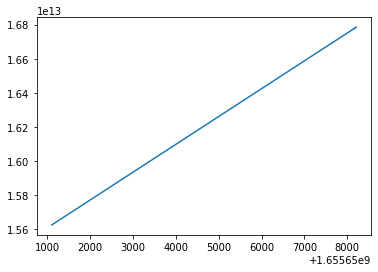

if_octets_tx


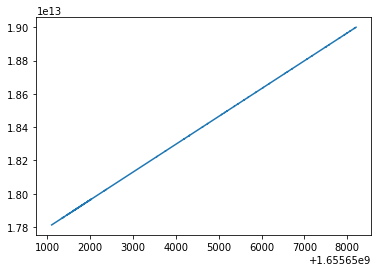

if_packets_rx


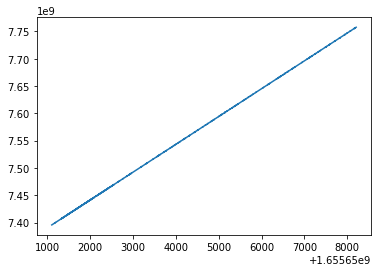

if_packets_tx


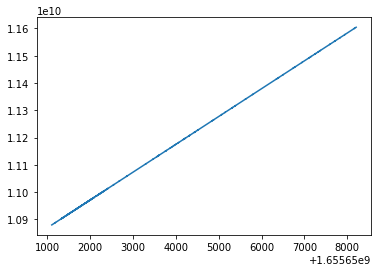

if_errors_rx


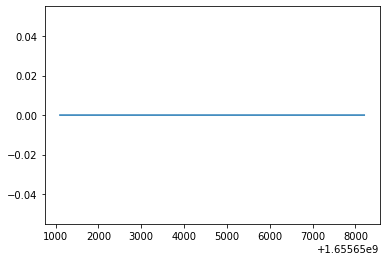

if_errors_tx


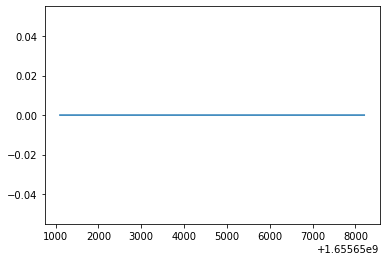

if_dropped_rx


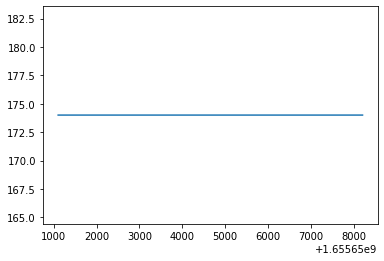

if_dropped_tx


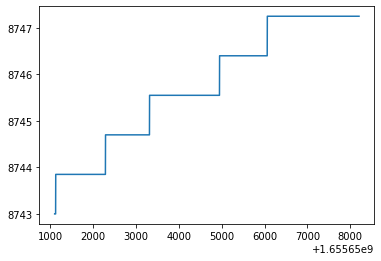

In [20]:
for i in syn_data_.columns:
    print(i)
    plt.plot(syn_data_[i])
    plt.show()

#### Save data

In [21]:
# ['memory-free', 'memory-used', 'percent-user', 'percent-system', 'percent-idle', 'shortterm', 'midterm', 'longterm']

for i in ['memory-free', 'memory-used', 'percent-user', 'percent-system', 'percent-idle', 'if_octets_rx',
       'if_octets_tx', 'if_packets_rx', 'if_packets_tx', 'if_errors_rx',
       'if_errors_tx', 'if_dropped_rx', 'if_dropped_tx']:
    syn_data_[i].to_csv('./syndata/'+foldername+'/'+str(i)+'.csv')

syn_data_[['shortterm', 'midterm', 'longterm']].to_csv('./syndata/'+foldername+'/'+'load.csv')

### Evaluate synthetic data

In [22]:
def zscore(Series):
    return (Series-Series.mean())/Series.std()
meta_data = meta_data[syn_data.columns][1:nentry+1]
syn_data = syn_data.apply(zscore)
meta_data = meta_data.apply(zscore)

In [23]:
syn_data

,memory-free,memory-used,percent-user,percent-system,percent-idle,shortterm,midterm,longterm
0,1.15,-1.58,-1.92,-1.16,1.69,-1.29,-1.01,-0.96
1,1.15,-1.58,-1.92,-1.15,1.70,-1.29,-1.15,-1.01
2,1.15,-1.59,-1.92,-1.15,1.70,-1.29,-1.29,-1.06
3,1.15,-1.59,-1.91,-1.15,1.70,-1.29,-1.29,-1.10
4,1.15,-1.59,-1.91,-1.15,1.70,-1.29,-1.29,-1.15
...,...,...,...,...,...,...,...,...
6995,0.54,-0.52,-0.37,-0.88,0.53,-0.59,-0.59,-0.73
6996,0.54,-0.52,-0.37,-0.88,0.53,-0.59,-0.59,-0.78
6997,0.54,-0.53,-0.37,-0.88,0.53,-0.59,-0.59,-0.82
6998,0.54,-0.53,-0.38,-0.88,0.53,-0.59,-0.73,-0.87


#### Wasserstein distance

In [24]:
def w_distance(real_data, syn_data):
    return wasserstein_distance(real_data, syn_data)

In [25]:
for i in range(len(meta_data.columns)):
    print(meta_data.columns[i])
    print(w_distance(meta_data.iloc[:, i], syn_data.iloc[:, i]))
    print("************")

memory-free
0.08885238357596137
************
memory-used
0.0674232112279697
************
percent-user
0.08513199133321026
************
percent-system
0.17825508865311968
************
percent-idle
0.10410866965131468
************
shortterm
0.07843228498164559
************
midterm
0.12483365596854887
************
longterm
0.26879681530884797
************


#### RMSE

In [26]:
def RMSE(real_data,syn_data):
    #numpy 格式 均方根误差
    return np.sqrt(np.mean((real_data-syn_data)**2))

In [27]:
for i in range(len(meta_data.columns)):
    print(meta_data.columns[i])
    print(RMSE(meta_data.iloc[:, i], syn_data.iloc[:, i]))
    print("************")

memory-free
0.2081791784087889
************
memory-used
0.28024968690169966
************
percent-user
0.35516608320189763
************
percent-system
0.7611540534949397
************
percent-idle
0.248822220029654
************
shortterm
0.1110439204346333
************
midterm
0.4421334950582854
************
longterm
0.9475665482755119
************


#### Mutual Information

In [28]:
def multal_info(real_data,syn_data):
    # 必须为1D 如Series
    from sklearn.metrics import mutual_info_score
    return mutual_info_score(real_data,syn_data)

In [29]:
for i in range(len(meta_data.columns)):
    print(meta_data.columns[i])
    print(multal_info(meta_data.iloc[:, i], syn_data.iloc[:, i]))
    print("************")

memory-free
8.843169199303254
************
memory-used
8.820539991116398
************
percent-user
8.85366542803745
************
percent-system
8.85366542803745
************
percent-idle
8.85366542803745
************
shortterm
7.1156579724847955
************
midterm
7.151595642756588
************
longterm
7.178531607453015
************


#### Distribution

In [30]:
def distribution(data, bins=20):
    return np.histogram(data, bins=bins)

memory-free


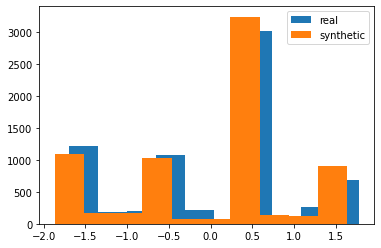

************
memory-used


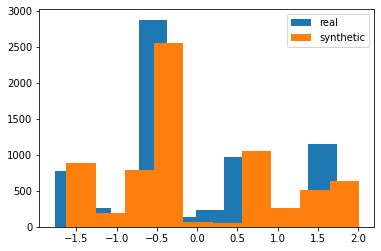

************
percent-user


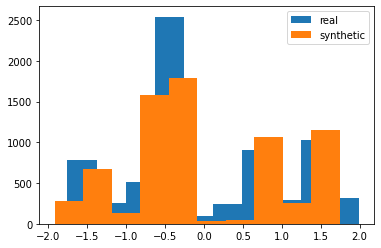

************
percent-system


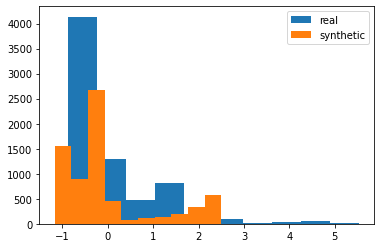

************
percent-idle


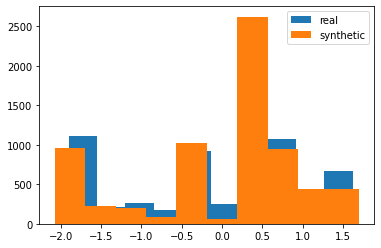

************
shortterm


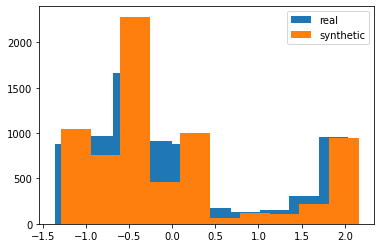

************
midterm


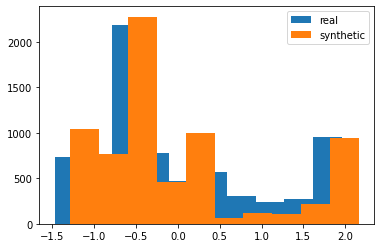

************
longterm


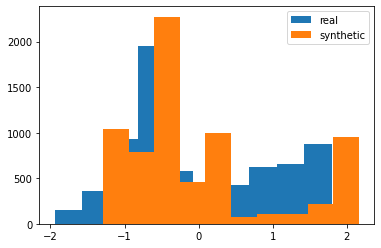

************


In [31]:
for i in range(len(meta_data.columns)):
    print(meta_data.columns[i])
    pic1 = plt.hist(meta_data.iloc[:, i])
    pic2 = plt.hist(syn_data.iloc[:, i])
    plt.legend(['real','synthetic'])
    plt.show()
    print("************")

#### Autocorrelation

In [32]:
def autocorrelation(data,maxLags=100):
    auto_corr = []

    for i in range(1, maxLags):
        corr = np.corrcoef(
            np.array([np.abs(data[:-i]), np.abs(data[i:])]))[0, 1]
        auto_corr.append(corr)
    return auto_corr

In [33]:
for i in range(len(meta_data.columns)):
    print(meta_data.columns[i])
    print('real:',np.mean(autocorrelation(meta_data.iloc[:, i])))
    print('synthetic:',np.mean(autocorrelation(syn_data.iloc[:, i])))
    print("************")

memory-free
real: 0.9540983899377229
synthetic: 0.9587941926753829
************
memory-used
real: 0.9607257945218066
synthetic: 0.9522278438208467
************
percent-user
real: 0.9221311146930946
synthetic: 0.9398313133633933
************
percent-system
real: 0.8599329250485789
synthetic: 0.9393817977887978
************
percent-idle
real: 0.9497568436741669
synthetic: 0.9586381334865993
************
shortterm
real: 0.9712425954313645
synthetic: 0.9660599412763183
************
midterm
real: 0.9811948387034355
synthetic: 0.9662126711832506
************
longterm
real: 0.9833698344708628
synthetic: 0.966413372049502
************


#### DTW

In [34]:
def DTW(real_data, syn_data):
    x = real_data
    y = syn_data
    distance, path = fastdtw(x,y)
    return distance

In [35]:
for i in range(len(meta_data.columns)):
    print(meta_data.columns[i])
    print(DTW(meta_data.iloc[:, i], syn_data.iloc[:, i]))
    print("************")

memory-free
391.6904312979881
************
memory-used
360.69865560128915
************
percent-user
526.7856219651171
************
percent-system
1266.3233140446848
************
percent-idle
471.8408378128206
************
shortterm
180.42775673000926
************
midterm
275.6217487004949
************
longterm
725.095814963858
************


#### MMD

In [36]:
def MMD(real_data, syn_data, kernel='multiscale', device='cpu'):
    """
    calculate the distribution distance using MMD
    :param real_data: original data
    :param syn_data: synthetic data
    :param kernel: str kernel method ('multiscale','rbf')
    :param device: str device('cpu','cuda:0')
    :return: MMD
    """    
    x = torch.tensor(real_data)
    y = torch.tensor(syn_data)
    
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a ** 2 * (a ** 2 + dxx) ** -1
            YY += a ** 2 * (a ** 2 + dyy) ** -1
            XY += a ** 2 * (a ** 2 + dxy) ** -1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5 * dxx / a)
            YY += torch.exp(-0.5 * dyy / a)
            XY += torch.exp(-0.5 * dxy / a)

    return torch.mean(XX + YY - 2. * XY).item()

In [37]:
print('MMD between the real and synthetic dataset:', MMD(meta_data.values, syn_data.values))

MMD between the real and synthetic dataset: 0.3094954192638397
